# Example 2: Kernel Interpolation

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import points, DSSIM, cf, cf_g, kernel_interp

plt.rcParams.update({'font.size': 12})

%reload_ext autoreload
%autoreload 2

## Definition of the target function/image

In [2]:
test_case = 1 # test_case = 0, 1 

from utils import get_test_function
f, fx, fy = get_test_function(test_case=test_case)

## Definition of the test set

In [3]:
dx = 5 * 1e-3
X_test, _, _ = points(dx)
y_test = f(X_test)

## Computation of the asymptotic constant

In [4]:
c_f = cf(f(X_test))

## Computation of the interpolants

In [5]:
# Fill distance
h = []

# DSSIM
dssim1 = []
dssim2 = []

# L2 error
l2_1 = []
l2_2 = []

# c_fg
g_dependent_const_1 = []
g_dependent_const_2 = []


# Run for different grid sizes
for k in range(1, 5):
    
    # Define the grid step size
    step = 4 * (2 ** (-(k - 1))) / 10
    
    # Get the interpolation points and the 1d grid used to generate them
    X, _, _ = points(step)
    print('Solving the interpolation problems with %5d nodes' % len(X))

    # Evaluate the function on the interpolation points and make it a square matrix    
    y = f(X)
    
    # Store the fill distance    
    h.append(np.sqrt(2) / 2 * step)
    
    # Compute the interpolant with the Wendland kernel
    val = kernel_interp(X, y, X_test, 'wendland')
    dssim1.append(DSSIM(val, y_test))
    l2_1.append(np.linalg.norm(val - y_test,2) ** 2 / y_test.shape[0])
    g_dependent_const_1.append(cf_g(val, f(X_test)))
    
    # Compute the interpolant with the Matern kernel
    val = kernel_interp(X, y, X_test, 'matern')
    dssim2.append(DSSIM(val, y_test))
    l2_2.append(np.linalg.norm(val - y_test, 2) ** 2  / y_test.shape[0])
    g_dependent_const_2.append(cf_g(val, f(X_test))) 

Solving the interpolation problems with    16 nodes
Solving the interpolation problems with    36 nodes
Solving the interpolation problems with   121 nodes
Solving the interpolation problems with   441 nodes


## Plot

### Cleanup

In [6]:
dssim1 = np.array(dssim1)
dssim2 = np.array(dssim2)

dssim1[np.where(dssim1<1e-16)[0]] = 1e-17
dssim2[np.where(dssim2<1e-16)[0]] = 1e-17

h = np.array(h)

g_dependent_const_1 = np.array(g_dependent_const_1)
g_dependent_const_2 = np.array(g_dependent_const_2)

l2_1 = np.array(l2_1)
l2_2 = np.array(l2_2)

### Estimation of the asymptotic rates

In [7]:
idx = np.argwhere(np.abs(dssim1) > 1e-16).ravel()
c1 = np.polyfit(np.log(h[idx]), np.log(dssim1[idx]), 1)
idx = np.argwhere(np.abs(dssim2) > 1e-16).ravel()
c2 = np.polyfit(np.log(h[idx]), np.log(dssim2[idx]), 1)

c_l2_1 = np.mean(np.array(dssim1) / (c_f * l2_1))
c_l2_2 = np.mean(np.array(dssim2) / (c_f * l2_2))

### Plot

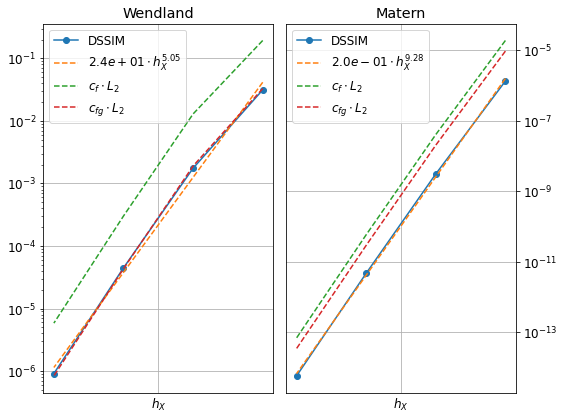

In [8]:
fig = plt.figure(figsize=(8, 6))
fig.clf()

ax = fig.add_subplot(1, 2, 1)
ax.loglog(h, dssim1, 'o-')
ax.loglog(h, np.exp(c1[1]) * h ** c1[0], '--')
ax.loglog(h, g_dependent_const_1 * l2_1, '--')
ax.loglog(h, c_l2_1 * c_f * l2_1, '--')
ax.grid(True)
ax.legend(['DSSIM', '$%1.1e \cdot h_X^{%2.2f}$' % (np.exp(c1[1]), c1[0]), 
           '$c_f \cdot L_2$', '$c_{fg} \cdot L_2$'],
           loc='upper left')
ax.set_xlabel('$h_X$')
ax.set_title('Wendland')
ax.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 

ax = fig.add_subplot(1, 2, 2)
ax.loglog(h, dssim2, 'o-')
ax.loglog(h, np.exp(c2[1]) * h ** c2[0], '--')
ax.loglog(h, c_f * l2_2, '--')
ax.loglog(h, g_dependent_const_2 * l2_2, '--')
ax.grid(True)
ax.legend(['DSSIM', '$%1.1e \cdot h_X^{%2.2f}$' % (np.exp(c2[1]), c2[0]), 
           '$c_f \cdot L_2$', '$c_{fg} \cdot L_2$'],
          loc='upper left')
ax.set_xlabel('$h_X$')
ax.set_title('Matern')
ax.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')

fig.tight_layout()
fig.savefig('kernel_' + str(test_case) + '.pdf')